# Birth Month Bias in the NHL
> Lets examine the effect that birth month has on players making it to the NHL, and the effect that it has on their career once they make it!

- comments: true

In [1]:
#hide
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from numpy import number
from bokeh.models import ColumnDataSource, HBar, Segment, Rect, Select, CustomJS, DataTable, TableColumn, RadioButtonGroup
from bokeh.layouts import layout, column, row
from bokeh.palettes import Colorblind
from datetime import datetime
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from IPython.core.display import display, HTML

In [2]:
#hide

def returnGrouping(month):
    early = ['January', 'February', 'March']
    earlyMid = ['April', 'May', 'June']
    lateMid = ['July', 'August', 'September']
    late = ['October', 'November', 'December']
    if month in early:
        return 'Early'
    elif month in earlyMid:
        return 'Early-Middle'
    elif month in lateMid:
        return 'Middle-Late'
    elif month in late:
        return 'Late'
    return 'None'

players_df = pd.read_csv(r"C:\Users\jacks\Development\Python\jcrs-blog\_notebooks\person.csv")
players_df['birth_date'] = pd.to_datetime(players_df['birth_date'], format="%Y-%m-%d %H:%M:%S-%f")
players_df['birth_month_number'] = players_df['birth_date'].dt.month
players_df['birth month'] = players_df['birth_date'].dt.month_name()
players_df['Year Grouping'] = players_df['birth month'].apply(returnGrouping)
players_df = players_df.sort_values(by='birth_month_number')

roster_df = pd.read_csv(r"C:\Users\jacks\Development\Python\jcrs-blog\_notebooks\roster.csv")
teams_df = pd.read_csv(r"C:\Users\jacks\Development\Python\jcrs-blog\_notebooks\teams.csv")
nhl_stats_df = pd.read_csv(r"C:\Users\jacks\Development\Python\jcrs-blog\_notebooks\playerStats.csv")
nhl_stats_df = nhl_stats_df[(nhl_stats_df['league_id'] == 133) & (nhl_stats_df['games'] > 9)]

reduced_stats_df = nhl_stats_df[[
    'person_id',
    'assists',
    'goals',
    'pim',
    'shots',
    'games',
    'hits',
    'power_play_goals',
    'power_play_assists',
    'blocked_shots',
    'shifts',
]]
career_stats_df = pd.DataFrame(reduced_stats_df.groupby(by='person_id', sort=False).sum())
birth_months_df = players_df[['person_id', 'Year Grouping', 'birth_month_number']]
career_stats_df = pd.merge(left=career_stats_df, right=birth_months_df, on='person_id')
career_stats_df = career_stats_df.sort_values(by='birth_month_number')
career_stats_df = career_stats_df[[
    'Year Grouping',
    'assists',
    'goals',
    'pim',
    'shots',
    'games',
    'hits',
    'power_play_goals',
    'power_play_assists',
    'blocked_shots',
    'shifts',]]
rename_map = {'power_play_goals': 'power play goals', 
              'power_play_assists': 'power play assists',
              'blocked_shots': 'blocked shots',
}
career_stats_df = career_stats_df.rename(columns=rename_map)
df = career_stats_df
career_stats_df['points'] = df['goals'] + df['assists']
career_stats_df['power play points'] = df['power play goals'] + df['power play assists'] 
career_stats_df['shooting percentage'] = df['goals'] / df['shots'] * 100

career_stats_by_game_df = pd.DataFrame()
career_stats_by_game_df['Year Grouping'] = career_stats_df['Year Grouping']
career_stats_by_game_df['assists'] = career_stats_df['assists'] / career_stats_df['games']
career_stats_by_game_df['goals'] = career_stats_df['goals'] / career_stats_df['games']
career_stats_by_game_df['points'] = career_stats_df['points'] / career_stats_df['games']
career_stats_by_game_df['pim'] = career_stats_df['pim'] / career_stats_df['games']
career_stats_by_game_df['shots'] = career_stats_df['shots'] / career_stats_df['games']
career_stats_by_game_df['hits'] = career_stats_df['hits'] / career_stats_df['games']
career_stats_by_game_df['power play goals'] = career_stats_df['power play goals'] / career_stats_df['games']
career_stats_by_game_df['power play assists'] = career_stats_df['power play assists'] / career_stats_df['games']
career_stats_by_game_df['power play points'] = career_stats_df['power play points'] / career_stats_df['games']
career_stats_by_game_df['blocked shots'] = career_stats_df['blocked shots'] / career_stats_df['games']
career_stats_by_game_df['shifts'] = career_stats_df['shifts'] / career_stats_df['games']

# grouping by Year Grouping for year grouping seaborn histogram
yearly_grouping_df = pd.DataFrame(career_stats_df['Year Grouping'].value_counts(sort=False))
yearly_grouping_percents_df = pd.DataFrame(career_stats_df['Year Grouping'].value_counts(sort=False, normalize=True))
yearly_grouping_df['Percent'] = yearly_grouping_percents_df['Year Grouping'] * 100
yearly_grouping_df['Percent'] = yearly_grouping_df['Percent'].round(1)

The ten thousand hour rule, popularized in Malcolm Gladwell's book Outliers, has become something of a mantra for a subculture of "rise and grinders" who strive to put in the time required to achieve mastery in their given vocations. While working hard to achieve excellence is certainly a worthy goal, an element of the concept is lost in the kind of "modern myth" which that rule has become. When Gladwell writes about the ten thousand hour rule, he is points out that for many people who achieve mastery in a field, there is an element of luck that allows them to put in far more time than many others. One example that he gives is the effect the birth month of a hockey player has on their chances of becoming a professional. That is, players born in the earlier months of the year seem to make it to the National Hockey League (NHL) in larger numbers than players born in the later months of the year. This post will examine if that rule still holds in todays NHL, and will go further to explore how birth month affects the careers of the players who do make it the NHL.

The chapter of Outliers that dives into this is based on a 1985 paper published by a group of Canadian phsycologists (R.H. Barnsley, A.H. Thompson, and P.E. Barnsley) titled 'Hockey Success and Birthdate: The Relative Age Effect'. It gives their findings that almost twice as many players making it to the NHL are born in the months of January, February, and March compared to the months of October, November, and December. The study found that if you divided the year into half, players born in the first half of the year represented a total of 61.8% of the player pool compared to 38.2% for the second half. They also found similar numbers in the junior system when examining the Western Hockey League and the Ontario Hockey League. Its suggested in the paper that this is the result of something called the Relative Age Effect, the ugly result of age grouping. In Canada, the cutoff date for minor hockey is December 31st of each year. This means a player born in January will be almost a full year older than a player born in December, but both will play on the same team. This gives the January born players a significant advantage, as older children will likely be stronger, faster, and more mentally developed than their opponents. In a competitive game like hockey this can provide a huge boost for players at an early stage of their development, and those players then become far more likely to be given the opportunities required to advance ahead of their peers and ultimately "make it" as a professional athelete.

Before diving into the data I think it's important to mention the restrictions I've placed on the dataset that the below visualizations are built on:
1. All the data is pulled from the NHL's open API
2. No data from the current season is included in the dataset
3. Only players who have played more than 9 games in one season are included in the dataset
4. Goaltenders are removed from the dataset, as their statistics don't compare with other positions
5. Only players who played after the NHL lockout (2005) are included. For the purposes of this post I'm considering that the "modern era" of the NHL.

So with that said here is how the data breaks out into the 4 categories: Early (born in January, February, March), Early-Middle (born in April, May, June), Middle-Late (born in July, August, September) and Late (born in October, November, and December).

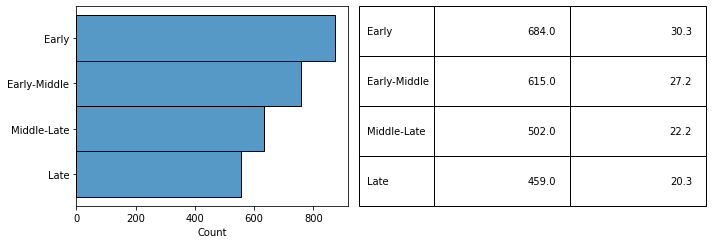

In [3]:
#hide_input
plt.rcParams["figure.autolayout"] = True

fig = plt.figure(figsize=(10,3.5))

ax1 = fig.add_subplot(122)
ax1.axis('off')
bbox = [0,0,1,1]
mpl_table = ax1.table(cellText =yearly_grouping_df.values, bbox=bbox, rowLabels=yearly_grouping_df.index)

ax2 = fig.add_subplot(121)
hist = sb.histplot(y='Year Grouping', data=players_df, ax=ax2)
hist.set(ylabel=None)

plt.show()


There are 684 (30.3%) players born in the 'Early' grouping months, while there are only 459 (20.3) players born in the 'Late' grouping. That is close to the 32.9% to 16.2% found by Barnsley et al. in 1985. It means that for every 10 players born in the months of October, November, or December who make the NHL there are roughly 15 born in the months of January, February, or March. This is just a visualization and it's not attempting to prove statistically significance, but those numbers certainly suggest a pronounced correlation. 

Given that the birth month trend certainly looks to be holding in today's NHL, let's explore a little deeper. Below is a boxplot without outliers (https://en.wikipedia.org/wiki/Box_plot). It visualizes the different percentiles players from each grouping fall into. Take the time to filter between the different stats available and see the trends, and checkout how this changes when you set it to show the stats on a per game basis rather than career totals.

In [44]:
#hide

output_notebook()
x_value = 'assists'
y_value = 'Year Grouping'

categories = career_stats_df[y_value].unique().tolist()
options = ['Total', 'By Game']

# if lower bound is less than zero, zero it
def greaterThanZero(x):
    return x if (x > 0) else 0

selections = ColumnDataSource(data = dict(selected=['assists'], by=[0]))
sources = {}
data_sources = { 0: {}, 1: {}};
select = 0;
x_axis_values = career_stats_df.select_dtypes([number]).columns

def calculate_quantiles(x, y, source_dataframe): 
    df = source_dataframe[[
        y, 
        x, 
    ]]
    groups = df.groupby(y)
    q1 = groups.quantile(q=0.25).reindex(categories)
    q2 = groups.quantile(q=0.5).reindex(categories)
    q3 = groups.quantile(q=0.75).reindex(categories)
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr
    lower[x] = lower[x].apply(greaterThanZero)
    
    source_dict = {
        'y': categories,
        'lower': lower[x],
        'q1': q1[x],
        'q2': q2[x],
        'q3': q3[x],
        'upper': upper[x]
    }
    return source_dict

for x_axis_value in x_axis_values: 
    total_dict = calculate_quantiles(x_axis_value, y_value, career_stats_df)
    data_sources[0][x_axis_value] = total_dict
    if (x_axis_value not in ['games', 'shooting percentage']):
        per_game_dict = calculate_quantiles(x_axis_value, y_value, career_stats_by_game_df)
        data_sources[1][x_axis_value] = per_game_dict  
    
tooltips = """
<div>
    <span style="font-size: 12px; font-weight: bold;">@y</span>&nbsp;
</div>
<div>
    <span style="font-size: 10px;">Lower bounds: @lower</span><br>
    <span style="font-size: 10px;">First quartile: @q1</span><br>
    <span style="font-size: 10px;">Median: @q2</span><br>
    <span style="font-size: 10px;">Third quartile: @q3</span><br>
    <span style="font-size: 10px;">Upper bounds: @upper</span>
</div>
"""
p = figure(y_range=categories[::-1], tooltips=tooltips, aspect_ratio=3, width=840, toolbar_location=None)

source = ColumnDataSource(data=data_sources[0][x_value])

hbar = HBar(
        y='y', 
        height=0.6,
        left='q1',
        right='q3',
        fill_color = Colorblind[8][0]
)

lower_segment = Segment(x0='lower', y0='y', x1='q1' ,y1='y')
upper_segment = Segment(x0='q3', y0='y', x1='upper' ,y1='y')
lower_rect = Rect(x='lower', y='y', width=0.001, height=0.8)
middle_rect = Rect(x='q2', y='y', width=0.001, height=0.8)
upper_rect = Rect(x='upper', y='y', width=0.001, height=0.8)

p.add_glyph(source, hbar)
p.add_glyph(source, lower_segment)
p.add_glyph(source, upper_segment)
p.add_glyph(source, lower_rect)
p.add_glyph(source, middle_rect)
p.add_glyph(source, upper_rect)

x_select = Select(options=x_axis_values.tolist(), value=x_value, width=420, height=30)
x_select.js_on_change("value", CustomJS(args=dict(source=source, data_sources=data_sources, selections=selections), 
code="""
    selections.data = {'selected': [this.value], 'by': [selections.data.by]};
    selections.change.emit();
    const new_data = data_sources[selections.data.by][this.value]
    source.data = new_data;
    source.change.emit();
"""))
breakout_radio = RadioButtonGroup(labels=options, active=0, width=420, height=30)
breakout_radio.js_on_click(CustomJS(args=dict(source=source, data_sources=data_sources, selections=selections), code="""
    selections.data = {'selected': [selections.data.selected], 'by': [this.active]};
    selections.change.emit();
    const new_data = data_sources[this.active][selections.data.selected[0]]
    source.data = new_data;
    source.change.emit();
    console.log(new_data)
"""))

columns = [
    TableColumn(field='y', title='Grouping'),
    TableColumn(field="lower", title='0th Percentile'),
    TableColumn(field="q1", title='25th Percentile'),
    TableColumn(field="q2", title='50th Percentile'),
    TableColumn(field="q3", title='75th Percentile'),
    TableColumn(field="upper", title='100th Percentile'),
]
table = DataTable(source=source, columns=columns, index_position=None, width=840,aspect_ratio=3)

layout = column(row(children=[x_select,breakout_radio], height=45, width=840), p, table)

output_file('birthmonth_boxplot.html')
# show the results
show(layout)

Loading BokehJS ...

In [40]:
#hide_input
HTML('./birthmonth_boxplot.html')

Its interesting data, and looking at the shape of it here's what I notice
1. Players from the later months seem to perform better in skill metrics both in career totals and on a per game basis. They look to be scoring more goals, recording more assists, and taking more shots than those players born in earlier months. 
2. The Early-Middle category is weird. The median players in this category are scoring almost 10 points less than the media Early players when looking at career totals. On a per game basis however they are scoring more than the Early category. Is it possible the spring months tend to turn out more injury prone players? There's more to look into here.
3. The Early category plays to their size advantage. They're throwing more hits, and recording more penalty minutes than the other categories.

This is just a visualization of the data, it's not trying to prove anything. It's job is to suggest trends in the data that could lead to more certainty. But with that said, it's time to draw some very loosely founded conclusions about what's being seen here. 

It's tempting to look at this and think that players born in the later months really are more skilled than those born in the earlier months; that they are traversing a road that places them at a disadvantage, and being rewarded with a more fruitful career. Personally, I think that is only part of what we're seeing here. Hockey is not just a skill game, good teams require players who can kill penalties, land big hits, and shutdown opposing scorers. In those roles there is a big advantage to being big (no pun intended). What is likely happening is that those roles are generally given to players born in the earlier months of the year, since as they are coming up through their minor hockey careers they are the players on the team who will tend to be bigger. They learn what it takes to play those roles, and when it comes time to compete for them at a NHL level they are the ones who have had the opportunity to get their 10,000 hours of heavy hockey in. 

So what's next in exploring this data? I think there is work to be done breaking the data up by position and nationality. Different countries have different cutoff dates, and it would be interesting to see if the effect is repeatable in different countries based on when those occur. Breaking the data down by position might show certain positions are more size dependant, and are likely filled by players born in the earlier months of the year. Perhaps defencemen's birthdates skew harder to the start of the year? Likely, Using some simple rules to classify players by the role they are most likely to play for a team and seeing how birth date correlates would lead somewhere interesting. 

For now, it certainly looks like the relative age effect is alive and well in the modern NHL.